# Battle of Neighborhoods - Where to live in Toronto?

1. A description of the problem and a discussion of the background. 

A wealthy family is looking to move from Brooklyn, NY to Toronto. Our firm is chosen to assist the family in identifying the best fitting Toronto borough for their lifestyle and needs. In recent years, Brooklyn has become the coolest borough of New York City with its vibrant mix of music festivals, big art and foodie scene, and trendy bars. 
Our firm has examined the boroughs of Toronto based on the existence of food and beverage estbalishments. The report below details the data sources and processes followed, findings and our recommendations to the client regarding the most suitable boroughs of Toronto to relocate. 

2. A description of the data and how it is be used to solve the problem.

In order to assist our client in the process, we utilized the following data sets and Foursquare API. 
- New York City Neighborhood Names data set from the NYU Spatial Data Repository (https://geo.nyu.edu/catalog/nyu_2451_34572)
- List of postal codes of Canada: M content from Wikipedia showing postal codes of Toronto (https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M) 

The NYC dataset was downloaded as a csv file, which includes zipcodes of NYC boroughs and associated latitudes and longitudes. Through Foursquare API, the most common venues of Brooklyn was identified. Following the development of more concrete information on Brooklyn, Toronto dataset was examined to determine areas that resemble Brooklyn the most.  

# Methodology

# Analyses and Results

Appropriate libraries are downloaded and analyses followed. 

In [1]:
from bs4 import BeautifulSoup
import requests
import csv

import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json 
from pandas.io.json import json_normalize 
import seaborn as sns

!conda install -c conda-forge geopy --yes 
from geopy.geocoders import Nominatim 
!conda install -c conda-forge folium=0.5.0 --yes 
import folium 


import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans # import k-means from clustering stage

print('Libraries imported.')

Solving environment: ...working... done

# All requested packages already installed.

Solving environment: ...working... done

# All requested packages already installed.

Libraries imported.


In [3]:
#Dataframe was created by reading the NYC dataset and includes 300 rows and 4 columns. 
NYC_df = pd.read_csv('/Users/cmumcu/Desktop/NYCboroughs.csv')
NYC_df.shape

(300, 4)

In [4]:
#The dataframe includes Zipcode, Borough, Latitude and Longitude.
print(NYC_df)

     Zipcode        Borough  Latitude  Longitude
0      11201       Brooklyn   40.6940   -73.9903
1      11203       Brooklyn   40.6505   -73.9349
2      11204       Brooklyn   40.6179   -73.9856
3      11205       Brooklyn   40.6924   -73.9666
4      11206       Brooklyn   40.7012   -73.9436
5      11207       Brooklyn   40.6705   -73.8940
6      11208       Brooklyn   40.6762   -73.8736
7      11209       Brooklyn   40.6251   -74.0303
8      11210       Brooklyn   40.6281   -73.9467
9      11211       Brooklyn   40.7095   -73.9563
10     11212       Brooklyn   40.6625   -73.9145
11     11213       Brooklyn   40.6700   -73.9367
12     11214       Brooklyn   40.6016   -73.9968
13     11215       Brooklyn   40.6669   -73.9828
14     11216       Brooklyn   40.6794   -73.9496
15     11217       Brooklyn   40.6816   -73.9798
16     11218       Brooklyn   40.6424   -73.9758
17     11219       Brooklyn   40.6336   -73.9960
18     11220       Brooklyn   40.6412   -74.0133
19     11221       B

In [5]:
#To examine the Brooklyn borough, a new dataframe is created with the Brooklyn data.
df_Brooklyn = NYC_df[NYC_df['Borough'].str.contains('Brooklyn',regex=False)]
df_Brooklyn

,Zipcode,Borough,Latitude,Longitude
0,11201,Brooklyn,40.6940,-73.9903
1,11203,Brooklyn,40.6505,-73.9349
2,11204,Brooklyn,40.6179,-73.9856
3,11205,Brooklyn,40.6924,-73.9666
4,11206,Brooklyn,40.7012,-73.9436
5,11207,Brooklyn,40.6705,-73.8940
6,11208,Brooklyn,40.6762,-73.8736
7,11209,Brooklyn,40.6251,-74.0303
8,11210,Brooklyn,40.6281,-73.9467
9,11211,Brooklyn,40.7095,-73.9563


In [6]:
#Brooklyn dataframe includes 37 rows and 4 columns. In other words, there are 37 zipcodes within Brooklyn borough. 
df_Brooklyn.shape

(37, 4)

In [7]:
#Utilizing FourSquare API to examine Brooklyn Borough
CLIENT_ID = 'I5BNVOQGS2VPHWYQCIVWRS4NVW1E3FHMUPRYNL5BT5EX1ZJ1' #  Foursquare ID
CLIENT_SECRET = 'KFMEF1Q51W4VD0EJUY5DP0KLQA5EXRQ1BWEVOZQZYOISDVHE' #  Foursquare Secret
VERSION = '20180604' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

In [8]:
#Creating a function to get all nearby venues
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    radius=500
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Borough', 
                  'Borough Latitude', 
                  'Borough Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    print('Found {} venues in {} neighborhoods.'.format(nearby_venues.shape[0], len(venues_list)))
    
    return(nearby_venues)

In [9]:
#Now filtering venues in Brooklyn and saving as a new dataframe called Brooklyn_venues
Brooklyn_venues = getNearbyVenues(names=df_Brooklyn['Borough'],
                                   latitudes=df_Brooklyn['Latitude'],
                                   longitudes=df_Brooklyn['Longitude']
                                  )

Brooklyn
Brooklyn
Brooklyn
Brooklyn
Brooklyn
Brooklyn
Brooklyn
Brooklyn
Brooklyn
Brooklyn
Brooklyn
Brooklyn
Brooklyn
Brooklyn
Brooklyn
Brooklyn
Brooklyn
Brooklyn
Brooklyn
Brooklyn
Brooklyn
Brooklyn
Brooklyn
Brooklyn
Brooklyn
Brooklyn
Brooklyn
Brooklyn
Brooklyn
Brooklyn
Brooklyn
Brooklyn
Brooklyn
Brooklyn
Brooklyn
Brooklyn
Brooklyn
Found 1567 venues in 37 neighborhoods.


Within the 37 zipcodes falling within Brooklyn, 1567 venues are identified.

In [10]:
#Let's present a snapshot of first 5 rows showcasing the columns on the Brooklyn_venues dataframe
Brooklyn_venues.head()

,Borough,Borough Latitude,Borough Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Brooklyn,40.694,-73.9903,SoulCycle Brooklyn Heights,40.692253,-73.991042,Cycle Studio
1,Brooklyn,40.694,-73.9903,Heatwise,40.693450,-73.991788,Yoga Studio
2,Brooklyn,40.694,-73.9903,Center for Brooklyn History,40.694942,-73.992333,History Museum
3,Brooklyn,40.694,-73.9903,Xtend Barre Brooklyn Heights,40.693599,-73.992376,Gym / Fitness Center
4,Brooklyn,40.694,-73.9903,Perelandra Natural Foods,40.693380,-73.991341,Grocery Store


The first five venues listed are SoulCycle Brooklyn Heights, Heatwise, Center for Brooklyn History, Xtend Barre Brooklyn Heights, and Perelandra Natural Foods which are representing five different categories of venues. 

In [11]:
#Let's group the data based on the category of venues to identify most common venues in the borough. 
Brooklyn_venues.groupby('Venue Category').count()

,Borough,Borough Latitude,Borough Longitude,Venue,Venue Latitude,Venue Longitude
Venue Category,,,,,,
Airport Terminal,1,1,1,1,1,1
American Restaurant,12,12,12,12,12,12
Arepa Restaurant,1,1,1,1,1,1
Argentinian Restaurant,1,1,1,1,1,1
Art Gallery,2,2,2,2,2,2
Arts & Crafts Store,2,2,2,2,2,2
Asian Restaurant,9,9,9,9,9,9
Automotive Shop,1,1,1,1,1,1
Bagel Shop,29,29,29,29,29,29


Although we found the necessary information, it is not easily interpretable. 

In [12]:
print('There are {} distinct venues in {} categories.'.format(
    len(Brooklyn_venues['Venue'].unique()),len(Brooklyn_venues['Venue Category'].unique())))

There are 1374 distinct venues in 232 categories.


In [13]:
#let's clean up this dataframe by removing unnecessary columns and presenting the table in a descending order to showcase most common venues on the top.
BrooklynVenues_category = Brooklyn_venues.groupby('Venue Category').count()
BrooklynVenues_Category = BrooklynVenues_category.drop(columns =['Borough', 'Borough Latitude', 'Borough Longitude', 'Venue Latitude', 'Venue Longitude'])
BrooklynVenues_Category.sort_values(by='Venue', ascending=False)

,Venue
Venue Category,
Pizza Place,85
Bar,59
Bakery,59
Coffee Shop,56
Chinese Restaurant,46
Deli / Bodega,44
Mexican Restaurant,42
Italian Restaurant,38
Café,33


The most common venues in Brooklyn are pizza places followed by bars, bakery, and coffee shop. It is important to highlight the prevalance of food and beverage establishments in the area. Nine of the 10 most common venue categories fall into food and beverage category. In addition, the area offers plenty of cafes and coffee shops along with bakeries to fulfill the pre-work breakfast run in the morning or for the afternoon coffee hangout. Moreover, restaurants offer variety of ethnic flavors along with pizza and deli carry out and American food. 

In [14]:
#Let's take a look at the Toronto data to identify boroughs similar to Brooklyn. 

In [15]:
###web scarping from the Wikipedia site
URL = 'https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'
source = requests.get(URL).text
soup = BeautifulSoup(source,'html.parser')

In [16]:
table_contents=[]
table=soup.find('table')
for row in table.findAll('td'):
    cell = {}
    if row.span.text=='Not assigned':
        pass
    else:
        cell['PostalCode'] = row.p.text[:3]
        cell['Borough'] = (row.span.text).split('(')[0]
        cell['Neighborhood'] = (((((row.span.text).split('(')[1]).strip(')')).replace(' /',',')).replace(')',' ')).strip(' ')
        table_contents.append(cell)
##print(table_contents)
df=pd.DataFrame(table_contents)
df['Borough']=df['Borough'].replace({'Downtown TorontoStn A PO Boxes25 The Esplanade':'Downtown Toronto Stn A',
                                             'East TorontoBusiness reply mail Processing Centre969 Eastern':'East Toronto Business',
                                             'EtobicokeNorthwest':'Etobicoke Northwest','East YorkEast Toronto':'East York/East Toronto',
                                             'MississaugaCanada Post Gateway Processing Centre':'Mississauga'})
df.head()

,PostalCode,Borough,Neighborhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,"Regent Park, Harbourfront"
3,M6A,North York,"Lawrence Manor, Lawrence Heights"
4,M7A,Queen's Park,Ontario Provincial Government


In [17]:
df.shape

(103, 3)

The dataframe for the Toronto includes 103 rows and 3 columns.

In [18]:
#Adding Latitude and Longitude
lat_long = pd.read_csv(r"C:\Users\cmumcu\Desktop\Geospatial_Coordinates.csv")
lat_long.head()

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


In [19]:
#Merging latitude and longitude info with the dataframe through postal codes. 
lat_long.rename(columns={'Postal Code':'PostalCode'},inplace=True)
df_new = pd.merge(df,lat_long,on='PostalCode')
df_new.head()

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763
4,M7A,Queen's Park,Ontario Provincial Government,43.662301,-79.389494


In [20]:
#Using FourSquare API to access the venue info for Toronto
CLIENT_ID = 'I5BNVOQGS2VPHWYQCIVWRS4NVW1E3FHMUPRYNL5BT5EX1ZJ1' #  Foursquare ID
CLIENT_SECRET = 'KFMEF1Q51W4VD0EJUY5DP0KLQA5EXRQ1BWEVOZQZYOISDVHE' #  Foursquare Secret
VERSION = '20180604' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

In [21]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    radius=500
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Borough', 
                  'Borough Latitude', 
                  'Borough Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    print('Found {} venues in {} boroughs.'.format(nearby_venues.shape[0], len(venues_list)))
    
    return(nearby_venues)

In [22]:
#Now filtering venues in Toronto and saving as a new dataframe called Toronto_venues
Toronto_venues = getNearbyVenues(names=df_new['Borough'],
                                   latitudes=df_new['Latitude'],
                                   longitudes=df_new['Longitude']
                                  )

North York
North York
Downtown Toronto
North York
Queen's Park
Etobicoke
Scarborough
North York
East York
Downtown Toronto
North York
Etobicoke
Scarborough
North York
East York
Downtown Toronto
York
Etobicoke
Scarborough
East Toronto
Downtown Toronto
York
Scarborough
East York
Downtown Toronto
Downtown Toronto
Scarborough
North York
North York
East York
Downtown Toronto
West Toronto
Scarborough
North York
North York
East York/East Toronto
Downtown Toronto
West Toronto
Scarborough
North York
North York
East Toronto
Downtown Toronto
West Toronto
Scarborough
North York
North York
East Toronto
Downtown Toronto
North York
North York
Scarborough
North York
North York
East Toronto
North York
York
North York
Scarborough
North York
North York
Central Toronto
Central Toronto
York
York
Scarborough
North York
Central Toronto
Central Toronto
West Toronto
Etobicoke
Scarborough
North York
Central Toronto
Central Toronto
West Toronto
Mississauga
Etobicoke
Scarborough
Central Toronto
Downtown Toronto
W

In [23]:
print(Toronto_venues.shape)
Toronto_venues.head()

(2130, 7)


,Borough,Borough Latitude,Borough Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,North York,43.753259,-79.329656,Brookbanks Park,43.751976,-79.332140,Park
1,North York,43.753259,-79.329656,KFC,43.754387,-79.333021,Fast Food Restaurant
2,North York,43.753259,-79.329656,Variety Store,43.751974,-79.333114,Food & Drink Shop
3,North York,43.725882,-79.315572,Victoria Village Arena,43.723481,-79.315635,Hockey Arena
4,North York,43.725882,-79.315572,Portugril,43.725819,-79.312785,Portuguese Restaurant


Within the boroughs of Toronto, 2130 venues are identified. Top five rows of the dataframe is displayed above. 

In [24]:
#Let's identify the number of venues at each borough of Toronto and sort by count
Summary = Toronto_venues.groupby('Borough').count().reset_index()
Summary['Count'] = Summary['Venue']
Summary = Summary.drop(['Borough Latitude', 'Borough Longitude', 'Venue', 'Venue Latitude', 'Venue Longitude','Venue Category'], axis=1)
Summary = Summary.sort_values('Count').reset_index(drop=True)
Summary.head()

,Borough,Count
0,East York/East Toronto,2
1,Etobicoke Northwest,5
2,Mississauga,14
3,East Toronto Business,18
4,York,18


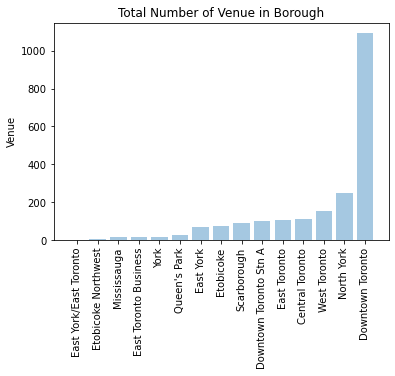

In [25]:
objects = Summary.Borough
y_pos = np.arange(len(objects))
performance = Summary.Count

plt.bar(y_pos, performance, align='center', alpha=0.4)
plt.xticks(y_pos, objects)
plt.ylabel('Venue')
plt.title('Total Number of Venue in Borough')
plt.xticks(rotation=90)

plt.show()

As the bar plot indicates, Downtown Toronto hosts more than 1000 of the total of 2130 venues in Toronto. North York, West Toronto and Central Toronto are the other boroughs with many venues although these areas host substantial less number of venues comparing to the downtown area. Solely based on the number of venues available, downtown Toronto appears to be a sutiable area. However, we miss the very key information; the type of venues available in these boroughs which will be essential in our client's decision making. 

In [26]:
#Analyzing each borough based on the venue information
#one hot encoding
Toronto_onehot = pd.get_dummies(Toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
Toronto_onehot['Borough'] = Toronto_venues['Borough'] 

# move neighborhood column to the first column
list_column = Toronto_onehot.columns.tolist()
number_column = int(list_column.index('Borough'))
list_column = [list_column[number_column]] + list_column[:number_column] + list_column[number_column+1:] 
Toronto_onehot = Toronto_onehot[list_column]

Toronto_onehot.head()

,Borough,Accessories Store,Adult Boutique,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Garage,Auto Workshop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Basketball Stadium,Beach,Bed & Breakfast,Beer Bar,Beer Store,Belgian Restaurant,Bike Shop,Bistro,Boat or Ferry,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bubble Tea Shop,Burger Joint,Burrito Place,Bus Line,Bus Station,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Camera Store,Candy Store,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Auditorium,College Gym,College Rec Center,College Stadium,Colombian Restaurant,Comfort Food Restaurant,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Curling Ice,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Escape Room,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Hakka Restaurant,Harbor / Marina,Hardware Store,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hockey Arena,Home Service,Hookah Bar,Hospital,Hostel,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Kids Store,Korean BBQ Restaurant,Korean Restaurant,Lake,Latin American Restaurant,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Luggage Store,Market,Martial Arts School,Massage Studio,Medical Center,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Motel,Movie Theater,Museum,Music Store,Music Venue,Nail Salon,Neighborhood,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Outdoor Sculpture,Park,Performing Arts Venue,Pet Store,Pharmacy,Pizza Place,Plane,Playground,Plaza,Poke Place,Pool,Portuguese Restaurant,Poutine Place,Print Shop,Pub,Ramen Restaurant,Record Shop,Recording Studio,Rental Car Location,Restaurant,River,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Shopping Plaza,Skate Park,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soccer Field,Social Club,Soup Place,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Stadium,Stationery Store,Steakhouse,Strip Club,Supermarket,Supplement Shop,Sushi Restaurant,Swim School,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Restaurant,Thrift / Vintage Store,Tibetan Restaurant,Toy / Game Store,Trail,Train Station,Truck Stop,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,North York,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

In [27]:
#Grouping rows by boroughs and taking the mean of the frequency of occurrence of each venue category
Toronto_byBorough = Toronto_onehot.groupby('Borough').mean().reset_index()
Toronto_byBorough.head()

,Borough,Accessories Store,Adult Boutique,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Garage,Auto Workshop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Basketball Stadium,Beach,Bed & Breakfast,Beer Bar,Beer Store,Belgian Restaurant,Bike Shop,Bistro,Boat or Ferry,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bubble Tea Shop,Burger Joint,Burrito Place,Bus Line,Bus Station,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Camera Store,Candy Store,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Auditorium,College Gym,College Rec Center,College Stadium,Colombian Restaurant,Comfort Food Restaurant,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Curling Ice,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Escape Room,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Hakka Restaurant,Harbor / Marina,Hardware Store,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hockey Arena,Home Service,Hookah Bar,Hospital,Hostel,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Kids Store,Korean BBQ Restaurant,Korean Restaurant,Lake,Latin American Restaurant,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Luggage Store,Market,Martial Arts School,Massage Studio,Medical Center,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Motel,Movie Theater,Museum,Music Store,Music Venue,Nail Salon,Neighborhood,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Outdoor Sculpture,Park,Performing Arts Venue,Pet Store,Pharmacy,Pizza Place,Plane,Playground,Plaza,Poke Place,Pool,Portuguese Restaurant,Poutine Place,Print Shop,Pub,Ramen Restaurant,Record Shop,Recording Studio,Rental Car Location,Restaurant,River,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Shopping Plaza,Skate Park,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soccer Field,Social Club,Soup Place,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Stadium,Stationery Store,Steakhouse,Strip Club,Supermarket,Supplement Shop,Sushi Restaurant,Swim School,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Restaurant,Thrift / Vintage Store,Tibetan Restaurant,Toy / Game Store,Trail,Train Station,Truck Stop,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,Central Toronto,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,

In [28]:
#Sorting most common venues on descending order
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [29]:
#New dataframe showing top 10 venues per borough
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Borough']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
boroughs_venues_sorted = pd.DataFrame(columns=columns)
boroughs_venues_sorted['Borough'] = Toronto_byBorough['Borough']

for ind in np.arange(Toronto_byBorough.shape[0]):
    boroughs_venues_sorted.iloc[ind, 1:] = return_most_common_venues(Toronto_byBorough.iloc[ind, :], num_top_venues)

boroughs_venues_sorted

,Borough,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Central Toronto,Sandwich Place,Coffee Shop,Park,Café,Pizza Place,Sushi Restaurant,Restaurant,Clothing Store,Dessert Shop,Diner
1,Downtown Toronto,Coffee Shop,Café,Hotel,Restaurant,Japanese Restaurant,Italian Restaurant,Park,Bakery,Pizza Place,Clothing Store
2,Downtown Toronto Stn A,Coffee Shop,Cocktail Bar,Seafood Restaurant,Japanese Restaurant,Restaurant,Café,Beer Bar,Hotel,Bakery,Italian Restaurant
3,East Toronto,Greek Restaurant,Coffee Shop,Italian Restaurant,Brewery,Ice Cream Shop,American Restaurant,Pizza Place,Pub,Café,Bakery
4,East Toronto Business,Yoga Studio,Pizza Place,Smoke Shop,Skate Park,Brewery,Burrito Place,Restaurant,Recording Studio,Park,Auto Workshop
5,East York,Coffee Shop,Bank,Sandwich Place,Pizza Place,Sporting Goods Shop,Burger Joint,Pharmacy,Beer Store,Athletics & Sports,Supermarket
6,East York/East Toronto,Park,Convenience Store,Yoga Studio,Eastern European Restaurant,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant
7,Etobicoke,Pizza Place,Sandwich Place,Coffee Shop,Pharmacy,Café,Bakery,Grocery Store,Gym,Park,Fast Food Restaurant
8,Etobicoke Northwest,Garden Center,Drugstore,Rental Car Location,Bar,Truck Stop,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Donut Shop
9,Mississauga,Coffee Shop,Hotel,Intersection,Middle Eastern Restaurant,Burrito Place,Sandwich Place,Fried Chicken Joint,Gas Station,American Restaurant,Mediterranean Restaurant


The table above shows the top 10 most common venue categories for the 14 boroughs of Toronto. This information is key in identifying the boroughs most suitable for our client's relocation. East and West Toronto appear to be the most suitable areas offering similar food and beverage establishments followed by Downtown Toronto STN A and Queen's Park. 

# Discussion

Based on the composition of venues available in Brooklyn, for our client, the most sutiable boroughs to move are East Toronto, West Toronto, Downtown Toronto Stn A, and Queen's Park. These boroughs of Toronto offer similar food and beverage establishments to our client and their family. In all these areas, variety of food and beverage establishments are available. As sought by our client, cafes, breakfast spots, variety of restaurants and bars are available to provide a seamless relocation and to help them feel home. 

# Conclusion

We wish our client and their family a seamless move. We hope one of these boroughs become their new home. If they request, we would offer additional services in finding a suitable house that will meet their needs. 